# Hour of edits
Analyses the hour of edits of anonymous and registered users in the pre-block, block and post-block periods. We want to explore this data to see if we can characterize internaliztion of users

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geoip2.database
from tqdm import tqdm
tqdm.pandas()

In [3]:
IP_DATA_PATH = "/scratch/ira"
PROCESSED_DATA_PATH = '/dlabdata1/turkish_wiki/processed_data'

In [4]:
edits = pd.read_csv(f'{PROCESSED_DATA_PATH}/all_edits.csv', index_col = 0)

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (6,7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [5]:
anonymous_edits = edits[edits.event_user_id.isna()]

In [6]:
def get_country_and_timezone(x):
    try:
        response = reader.city(x['event_user_text_historical'])
        x['country_code'] = response.country.iso_code
        x['timezone'] = response.location.time_zone
    except:
        x['country_code'] = np.nan
        x['timezone'] = np.nan
    return x

## 1) Process anonymous edit IPs to get the country of anonymous users

In [110]:
# anonymous_edits = anonymous_edits.progress_apply(get_country_and_timezone, axis=1)

100%|██████████| 3525634/3525634 [48:42<00:00, 1206.56it/s] 


In [111]:
# anonymous_edits.to_csv(f'{PROCESSED_DATA_PATH}/anonymous_edits_ip.csv', index = False)

In [10]:
anonymous_edits = pd.read_csv(f'{PROCESSED_DATA_PATH}/anonymous_edits_ip.csv')

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (5,6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
block_dates = [pd.to_datetime('2017-04-29', utc = True), pd.to_datetime('2020-01-15 19:00', utc = True)]
blocked_days = (block_dates[1] - block_dates[0]).days

In [12]:
anonymous_edits['event_timestamp'] = pd.to_datetime(anonymous_edits['event_timestamp'],   utc = True)

In [13]:
anonymous_edits = anonymous_edits[anonymous_edits['event_timestamp'] >= block_dates[0]-pd.Timedelta(days=blocked_days)]
anonymous_edits['Hour'] = anonymous_edits.event_timestamp.dt.strftime("%H")
anonymous_edits['period'] = anonymous_edits.apply(lambda row: 'pre-block' if row['event_timestamp'] < block_dates[0] else 'block' if not row['event_timestamp'] >= block_dates[1] else 'after-block', axis=1)

KeyboardInterrupt: 

In [ ]:
anonymous_edits['is_from_Turkey'] = anonymous_edits['country_code'] == 'TR'

In [258]:
hourly_anon_edits = anonymous_edits.groupby(['period', 'is_from_Turkey', 'Hour']).count()[['event_timestamp']]

In [259]:
hourly_anon_edits.columns = ['count']

In [260]:
hourly_anon_edits['percent'] =  hourly_anon_edits['count'].div(hourly_anon_edits['count'].sum(level=[0,1]))

In [261]:
hourly_anon_edits = hourly_anon_edits.reset_index()

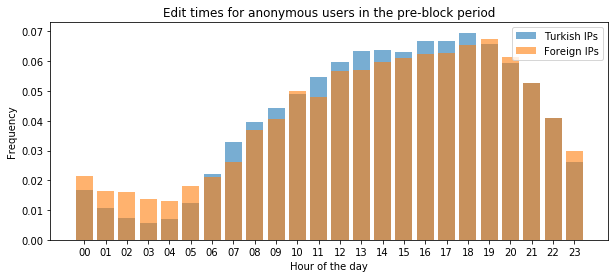

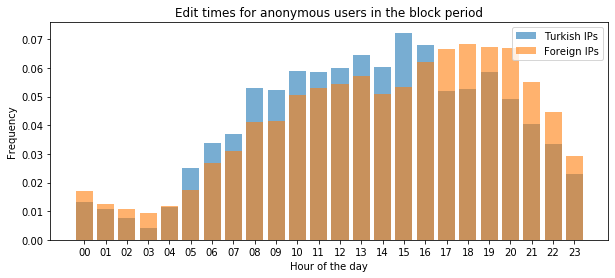

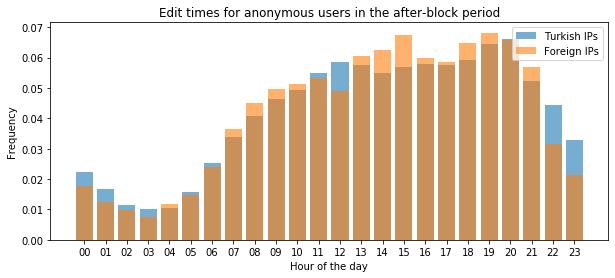

In [263]:
for i, period in enumerate(['pre-block', 'block', 'after-block']):
    plt.figure(figsize=(10,4))
    for is_from_turkey in [True, False]:
        df = hourly_anon_edits[(hourly_anon_edits.period == period) & (hourly_anon_edits.is_from_Turkey == is_from_turkey)]
        label = 'Turkish IPs' if is_from_turkey else 'Foreign IPs'
        plt.bar(df['Hour'], df['percent'], alpha = 0.6, label=label)

    plt.title(f'Edit times for anonymous users in the {period} period')
    plt.legend(loc='upper right')
    # The following commands add labels to our figure.
    plt.xlabel('Hour of the day')
    plt.ylabel('Frequency')


    plt.show()

In [264]:
account_edits = edits[~edits.event_user_id.isna()]

In [265]:
account_edits['event_timestamp'] = pd.to_datetime(account_edits['event_timestamp'],   utc = True)
account_edits = account_edits[account_edits['event_timestamp'] >= block_dates[0]-pd.Timedelta(days=blocked_days)]
account_edits['Hour'] = account_edits.event_timestamp.dt.strftime("%H")
account_edits['period'] = account_edits.apply(lambda row: 'pre-block' if row['event_timestamp'] < block_dates[0] else 'block' if not row['event_timestamp'] >= block_dates[1] else 'after-block', axis=1)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [266]:
hourly_account_edits = account_edits.groupby(['period', 'Hour']).count()[['event_timestamp']]
hourly_account_edits.columns = ['count']
hourly_account_edits['percent'] =  hourly_account_edits['count'].div(hourly_account_edits['count'].sum(level=0),level=0)
hourly_account_edits = hourly_account_edits.reset_index()

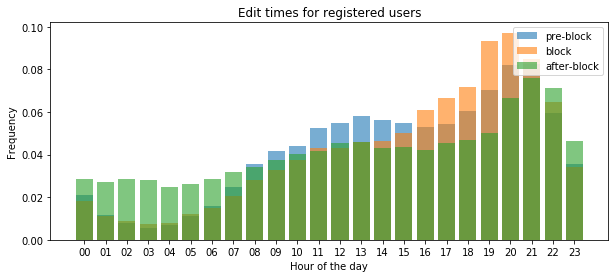

In [267]:
plt.figure(figsize=(10,4))
for i, period in enumerate(['pre-block', 'block', 'after-block']):
    df = hourly_account_edits[(hourly_account_edits.period == period)]
    plt.bar(df['Hour'], df['percent'], alpha = 0.6,  label=period)

# The following commands add labels to our figure.
plt.xlabel('Hour of the day')
plt.ylabel('Frequency')
plt.legend(loc='upper right')


plt.title(f'Edit times for registered users')


plt.show()

In [271]:
hourly_all_anon_edits = hourly_anon_edits[hourly_anon_edits['period'] =='pre-block'].groupby('Hour')['count'].sum()
hourly_all_anon_edits /= hourly_all_anon_edits.sum()
hourly_all_anon_edits = hourly_all_anon_edits.reset_index()
hourly_all_anon_edits.columns = ['Hour', 'percent']

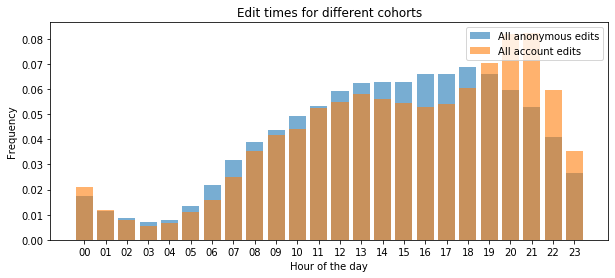

In [273]:
plt.figure(figsize=(10,4))
for i, df in enumerate([hourly_all_anon_edits, hourly_account_edits[(hourly_account_edits.period == 'pre-block')]]):
    label = 'All anonymous edits' if i==0 else 'All account edits'
    plt.bar(df['Hour'], df['percent'], alpha= 0.6,  label=label)

# The following commands add labels to our figure.
plt.title('Edit times for different cohorts')
plt.xlabel('Hour of the day')
plt.ylabel('Frequency')
plt.legend(loc='upper right')


plt.show()

As we can see, counting the total edit number per hour gives great differences in terms of the distributions between anonymous and registered account edits. My hypothesis is that this difference comes from the multplicity of edits per user in a given hour. In the next part I'm going to count unique user ids per day and hour.

## Unique user edits

In [279]:
anonymous_edits['Day'] = anonymous_edits.event_timestamp.dt.strftime("%Y-%m-%d")

In [279]:
hourly_anon_edits = anonymous_edits.groupby(['period', 'is_from_Turkey', 'Hour', 'Day'])[['event_user_text_historical']].nunique()
hourly_anon_edits.columns = ['count']
hourly_anon_edits = hourly_anon_edits.groupby(['period', 'is_from_Turkey', 'Hour']).sum()
hourly_anon_edits['percent'] =  hourly_anon_edits['count'].div(hourly_anon_edits['count'].sum(level=[0,1]))
hourly_anon_edits = hourly_anon_edits.reset_index()

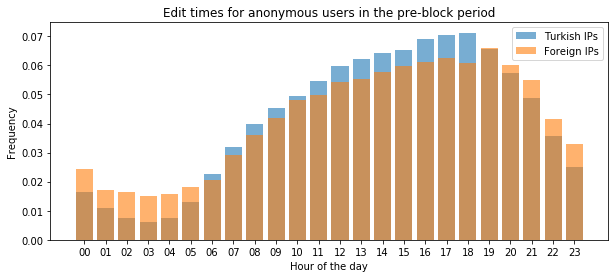

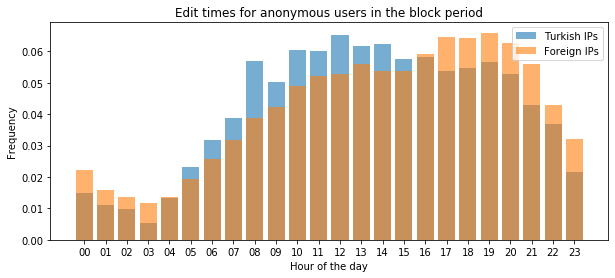

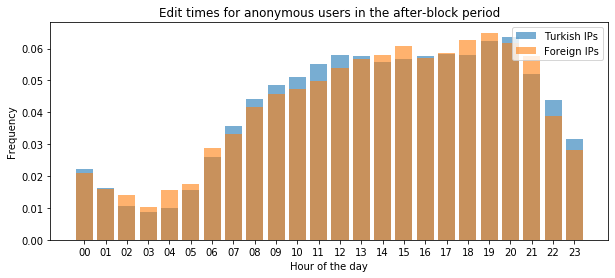

In [280]:
for i, period in enumerate(['pre-block', 'block', 'after-block']):
    plt.figure(figsize=(10,4))
    for is_from_turkey in [True, False]:
        df = hourly_anon_edits[(hourly_anon_edits.period == period) & (hourly_anon_edits.is_from_Turkey == is_from_turkey)]
        label = 'Turkish IPs' if is_from_turkey else 'Foreign IPs'
        plt.bar(df['Hour'], df['percent'], alpha = 0.6, label=label)

    plt.title(f'Edit times for anonymous users in the {period} period')
    plt.legend(loc='upper right')
    # The following commands add labels to our figure.
    plt.xlabel('Hour of the day')
    plt.ylabel('Frequency')

    plt.show()

In [281]:
account_edits['Day'] = account_edits.event_timestamp.dt.strftime("%Y-%m-%d")

KeyError: 'is_from_Turkey'

In [286]:
hourly_account_edits = account_edits.groupby(['period', 'Hour', 'Day'])[['event_user_id']].nunique()
hourly_account_edits.columns = ['count']
hourly_account_edits = hourly_account_edits.groupby(['period',  'Hour']).sum()
hourly_account_edits['percent'] =  hourly_account_edits['count'].div(hourly_account_edits['count'].sum(level=0),level=0)
hourly_account_edits = hourly_account_edits.reset_index()

In [287]:
hourly_all_anon_edits = hourly_anon_edits[hourly_anon_edits['period'] =='pre-block'].groupby('Hour')['count'].sum()
hourly_all_anon_edits /= hourly_all_anon_edits.sum()
hourly_all_anon_edits = hourly_all_anon_edits.reset_index()
hourly_all_anon_edits.columns = ['Hour', 'percent']

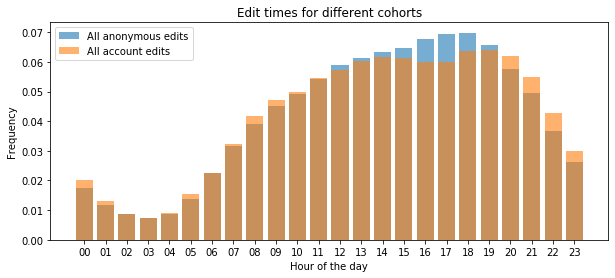

In [301]:
plt.figure(figsize=(10,4))
for i, df in enumerate([hourly_all_anon_edits, hourly_account_edits[(hourly_account_edits.period == 'pre-block')]]):
    label = 'All anonymous edits' if i==0 else 'All account edits'
    plt.bar(df['Hour'], df['percent'], alpha= 0.6,  label=label)

# The following commands add labels to our figure.
plt.title('Edit times for different cohorts')
plt.xlabel('Hour of the day')
plt.ylabel('Frequency')
plt.legend(loc='upper left')


plt.show()

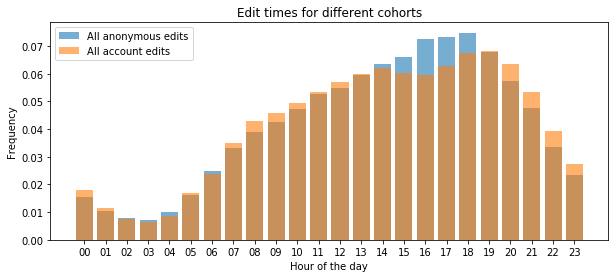

In [341]:
hourly_anon_edits = anonymous_edits[anonymous_edits['event_timestamp'] > date_of_timezone_change].groupby(['period', 'is_from_Turkey', 'Hour', 'Day'])[['event_user_text_historical']].nunique()
hourly_anon_edits.columns = ['count']
hourly_anon_edits = hourly_anon_edits.groupby(['period', 'is_from_Turkey', 'Hour']).sum()
hourly_anon_edits['percent'] =  hourly_anon_edits['count'].div(hourly_anon_edits['count'].sum(level=[0,1]))
hourly_anon_edits = hourly_anon_edits.reset_index()

hourly_account_edits = account_edits[account_edits['event_timestamp'] > date_of_timezone_change].groupby(['period', 'Hour', 'Day'])[['event_user_id']].nunique()
hourly_account_edits.columns = ['count']
hourly_account_edits = hourly_account_edits.groupby(['period',  'Hour']).sum()
hourly_account_edits['percent'] =  hourly_account_edits['count'].div(hourly_account_edits['count'].sum(level=0),level=0)
hourly_account_edits = hourly_account_edits.reset_index()

hourly_all_anon_edits = hourly_anon_edits[hourly_anon_edits['period'] =='pre-block'].groupby('Hour')['count'].sum()
hourly_all_anon_edits /= hourly_all_anon_edits.sum()
hourly_all_anon_edits = hourly_all_anon_edits.reset_index()
hourly_all_anon_edits.columns = ['Hour', 'percent']

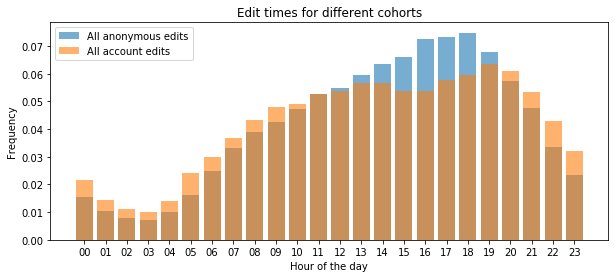

In [348]:
plt.figure(figsize=(10,4))
for i, df in enumerate([transform_df(hourly_anon_edits, 'block'), hourly_account_edits[(hourly_account_edits.period == 'block')]]):
    label = 'All anonymous edits' if i==0 else 'All account edits'
    plt.bar(df['Hour'], df['percent'], alpha= 0.6,  label=label)

# The following commands add labels to our figure.
plt.title('Edit times for different cohorts')
plt.xlabel('Hour of the day')
plt.ylabel('Frequency')
plt.legend(loc='upper left')

plt.show()

In [346]:
def transform_df(df, period):
    hourly_all_anon_edits = df[df['period'] =='pre-block'].groupby('Hour')['count'].sum()
    hourly_all_anon_edits /= hourly_all_anon_edits.sum()
    hourly_all_anon_edits = hourly_all_anon_edits.reset_index()
    hourly_all_anon_edits.columns = ['Hour', 'percent']
    return hourly_all_anon_edits

In [1]:
hourly_anon_edits.pivot_table(index = 'Hour', columns = ['period', 'is_from_Turkey'], values = 'percent')['pre-block']

NameError: name 'hourly_anon_edits' is not defined

In [352]:
from sklearn.linear_model import LinearRegression

In [388]:
X = hourly_anon_edits.pivot_table(index = 'Hour', columns = ['period', 'is_from_Turkey'], values = 'percent')['pre-block']
reg = LinearRegression().fit(X, hourly_account_edits[hourly_account_edits['period'] == 'pre-block']['percent'])
reg.coef_

array([0.32191366, 0.61674524])

In [405]:
X = hourly_anon_edits.pivot_table(index = 'Hour', columns = ['period', 'is_from_Turkey'], values = 'percent')['pre-block']
Y = hourly_account_edits[hourly_account_edits['period'] == 'after-block']['percent']


In [406]:
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
model = sm.OLS(Y.values, X.values)
model2=model.fit_regularized(method='elastic_net', alpha=0.0, L1_wt=1.0, start_params=None, profile_scale=False, refit=False)
model2.params

array([0.63561779, 0.32941677])